In [2]:
import os, sys, re

os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ["ADAPTIVE_PREFERENCE_ENV"] = "dev"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# SETTINGS - MANUAL ------------------------------------------------------

APP_VERSION = "Binary MPC - MU-Agg"
OUTPUT_FILE = "binmpc_mu-agg"
IS_MPC = True
target_dir = os.path.expanduser("~/ryandew_adaptive_preference/RA/results_analysis/understanding_prefs/binmpc_mu-agg/outputs/")

item_data = pd.read_csv(os.path.expanduser("~/ryandew_adaptive_preference/RA/backend/data/dresses10_urls.csv"))
train_df = pd.read_csv(os.path.expanduser('~/Dropbox/1_proj/urbn/results/binary_mpc_results/analysis-7.3-aggregated-fixed-binary-mpc-None/train_df.csv'))
test_df = pd.read_csv(os.path.expanduser('~/Dropbox/1_proj/urbn/results/binary_mpc_results/analysis-7.3-aggregated-fixed-binary-mpc-None/test_df.csv'))
ind_df = pd.read_csv(os.path.expanduser('~/Dropbox/1_proj/urbn/results/binary_mpc_results/analysis-7.3-aggregated-fixed-binary-mpc-None/individuals.csv'))

# Exclude people who do not pass attention check:
train_df = train_df.loc[ind_df['passed_redisplay'] == 1,:]
test_df = test_df.loc[ind_df['passed_redisplay'] == 1,:]

In [4]:
e_all = item_data.loc[:,"E1":].values

## Helper Function to format data for MPC studies.

def create_pairs(dresses):
    dresses_cols = [col for col in dresses.columns if re.compile(r"E\d+").match(col)]  # Columns like E1, E2, ...
    indexed_dresses = dresses.reset_index(drop=False)  # dresses dataframe with indices ranging from 0 to N
    # Artificial column for catesian product. Pandas version is too low to use how="cross"
    indexed_dresses["_merge_key"] = 0
    merged_all_dresses = pd.merge(indexed_dresses, indexed_dresses, on="_merge_key", how="inner", suffixes=("_1", "_2"))
    merged_filtered_dresses = merged_all_dresses[merged_all_dresses["index_1"] < merged_all_dresses["index_2"]]
    for ix, col in enumerate(dresses_cols, 1):
        merged_filtered_dresses[f"Diff{ix}"] = merged_filtered_dresses[f"{col}_1"] - merged_filtered_dresses[f"{col}_2"]
    return merged_filtered_dresses[
        ["Item_ID_1", "Item_ID_2", "URL_1", "URL_2"] + [f"Diff{ix}" for ix, _ in enumerate(dresses_cols, 1)]
    ].reset_index(drop=True)

pairs_data = create_pairs(item_data)
z_all = pairs_data.loc[:,"Diff1":].values

In [5]:
e_pred_df = pd.read_csv("~/Dropbox/1_proj/urbn/results/7.x_understanding_prefs/pred_user_ratings.csv", index_col=0)

In [6]:
prod_atts = pd.read_csv("~/ryandew_adaptive_preference/RA/backend/data/nuuly_product_attributes.csv")
prod_atts = prod_atts[prod_atts['choiceId'].isin(item_data['Item_ID'])]
prod_atts.fillna(False, inplace=True)
prod_atts.set_index('choiceId', inplace=True)
prod_atts = prod_atts.rename_axis('Item_ID')
prod_atts = prod_atts.loc[:, prod_atts.sum(axis=0) >= 50]
prod_atts = prod_atts.loc[:, prod_atts.sum(axis=0) <= 750]

/tmp/ipykernel_1863053/4218620129.py:1: DtypeWarning: Columns (5,7,9,16,27,28,35,36,71,72,73,74,75,76,83,88,95,96,102,114,120,121,127,128,135,138,139,140,141,148,157,162,164,198,199,200,201,202,203,205,210,224,225,227,229,230,231,233,235,237,239,240,242,245,254,259,281,291,296,297,323,328,329) have mixed types. Specify dtype option on import or set low_memory=False.
  prod_atts = pd.read_csv("~/ryandew_adaptive_preference/RA/backend/data/nuuly_product_attributes.csv")


Some interesting attributes to consider:

- facets_dressLength_Mini 
- facets_fabric_Cotton
- facets_constructionDetails_Button_Closure 
- facets_patternTypeAndOrScale_Floral 
- facets_sleeveLength_Sleeveless

# IPW: Average

In [7]:
item_data.set_index('Item_ID', inplace=True)

In [8]:
interesting_atts = [
    'facets_fabric_Cotton',
    'facets_dressLength_Mini',
    'facets_constructionDetails_Button_Closure',
    'facets_patternTypeAndOrScale_Floral',
    'facets_sleeveLength_Sleeveless'
]

In [9]:
feat_data = item_data.loc[:,"E1":].merge(prod_atts, left_index=True, right_index=True)

rating_df = pd.DataFrame({'Item_ID': item_data.index, 'Avg_Rating': e_pred_df.mean(axis=0)})
rating_df.set_index('Item_ID', inplace=True)
feat_data = feat_data.merge(rating_df, left_index=True, right_index=True)
feat_data

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,facets_sleeveLength_3_4_Sleeve,facets_sleeveLength_Long_Sleeve,facets_sleeveLength_Short_Sleeve,facets_sleeveLength_Sleeveless,facets_sleeveType_Cuffed,facets_sleeveType_Puff,facets_sleeveType_Relaxed,facets_weather_Warm_Weather,facets_weather_Year_Round,Avg_Rating
Item_ID,,,,,,,,,,,,,,,,,,,,,
53783866_010,0.243,-0.106,-0.380,0.620,-0.046,0.024,-0.199,0.526,0.033,-0.229,...,True,False,False,False,False,False,True,True,False,-0.106292
54228515_237,0.461,0.475,0.172,0.137,-0.107,0.239,0.532,0.268,-0.148,0.130,...,False,True,False,False,False,False,True,True,False,-0.179844
54685284_000,-0.176,0.193,0.469,0.573,0.325,-0.299,0.081,0.127,0.269,-0.268,...,False,False,False,True,False,False,False,True,False,-0.069827
52190816_024,-0.400,0.493,-0.213,0.218,0.036,-0.237,-0.018,0.596,0.111,0.196,...,True,False,False,False,False,False,True,False,True,-0.061947
55047476_000,-0.112,-0.149,0.285,0.020,0.249,0.362,-0.392,0.576,0.389,0.043,...,False,False,False,True,False,False,False,True,False,-0.056752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4130292120004_009,-0.044,0.247,-0.041,0.012,0.073,-0.070,0.367,0.108,-0.807,0.325,...,False,True,False,False,False,False,True,True,True,-0.118973
54724703_011,0.231,-0.420,0.158,0.171,-0.380,0.220,0.278,-0.115,0.648,0.019,...,False,False,True,False,False,True,False,True,False,-0.078732
54681093_009,0.214,-0.370,0.227,0.506,0.426,-0.117,0.464,0.272,0.150,-0.060,...,False,False,False,True,False,False,False,True,False,-0.232297


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feat_data.loc[:, 'E1':'E10'], feat_data['facets_fabric_Cotton'], test_size=0.2, random_state=42)

# Fit a logistic regression model on the training set
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Evaluate the model on the testing set
score = lr.score(X_test, y_test)
print(f"Accuracy: {score}")

Accuracy: 0.7791411042944786


In [11]:
feat_data['facets_fabric_Cotton_Prob'] = lr.predict_proba(feat_data.loc[:, 'E1':'E10'])[:, 1]

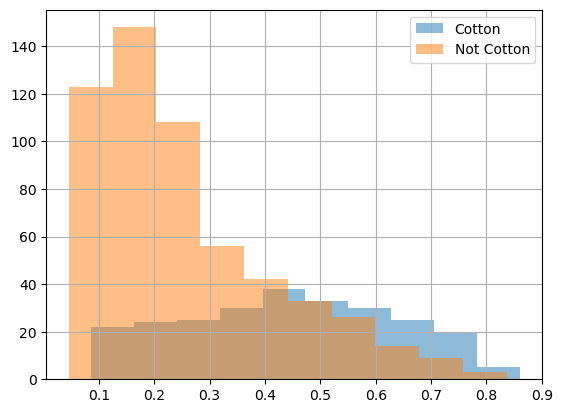

In [12]:
feat_data[feat_data['facets_fabric_Cotton'] == True]['facets_fabric_Cotton_Prob'].hist(alpha=0.5, label='Cotton')
feat_data[feat_data['facets_fabric_Cotton'] == False]['facets_fabric_Cotton_Prob'].hist(alpha=0.5, label='Not Cotton')
plt.legend()
plt.show()


In [13]:
# Step 1: Compute inverse probability weights
class_probs = lr.predict_proba(feat_data.loc[:, 'E1':'E10'])
feat_data['weights'] = 1 / np.where(feat_data['facets_fabric_Cotton'], class_probs[:, 1], class_probs[:, 0])

# Step 2: Compute weighted averages
treatment_avg_rating = np.average(feat_data.loc[feat_data['facets_fabric_Cotton'] == True, 'Avg_Rating'], weights=feat_data.loc[feat_data['facets_fabric_Cotton'] == True, 'weights'])
control_avg_rating = np.average(feat_data.loc[feat_data['facets_fabric_Cotton'] == False, 'Avg_Rating'], weights=feat_data.loc[feat_data['facets_fabric_Cotton'] == False, 'weights'])

# Step 3: Compute treatment effect estimate
ipw_estimate = treatment_avg_rating - control_avg_rating
print(f"IPW estimate of effect of facets_fabric_Cotton on Avg_Rating: {ipw_estimate}")

IPW estimate of effect of facets_fabric_Cotton on Avg_Rating: 0.0058837812444513665


In [14]:
def compute_ipw_estimate(feat_data, feature):
    print(f"Feature: {feature}")
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(feat_data.loc[:, 'E1':'E10'], feat_data[feature], test_size=0.2, random_state=42)

    # Fit a logistic regression model on the training set
    lr = LogisticRegression()
    lr.fit(X_train, y_train)

    # Evaluate the model on the testing set
    score = lr.score(X_test, y_test)
    print(f"Accuracy: {score}")

    # Compute inverse probability weights
    # Step 1: Compute inverse probability weights
    class_probs = lr.predict_proba(feat_data.loc[:, 'E1':'E10'])
    feat_data['weights'] = 1 / np.where(feat_data[feature], class_probs[:, 1], class_probs[:, 0])
    
    # Print min and max probs for feature = True vs False
    print(f"Min prob for {feature} = True: {class_probs[feat_data[feature] == True, 1].min()}")
    print(f"Max prob for {feature} = True: {class_probs[feat_data[feature] == True, 1].max()}")
    print(f"Min prob for {feature} = False: {class_probs[feat_data[feature] == False, 1].min()}")
    print(f"Max prob for {feature} = False: {class_probs[feat_data[feature] == False, 1].max()}")

    # Compute weighted averages
    treatment_avg_rating = np.average(feat_data.loc[feat_data[feature] == True, 'Avg_Rating'], weights=feat_data.loc[feat_data[feature] == True, 'weights'])
    control_avg_rating = np.average(feat_data.loc[feat_data[feature] == False, 'Avg_Rating'], weights=feat_data.loc[feat_data[feature] == False, 'weights'])

    # Compute treatment effect estimate
    ipw_estimate = treatment_avg_rating - control_avg_rating
    print(f"IPW estimate of effect of {feature} on Avg_Rating: {ipw_estimate}")
    return ipw_estimate


In [15]:
compute_ipw_estimate(feat_data, "facets_fabric_Cotton");

Feature: facets_fabric_Cotton
Accuracy: 0.7791411042944786
Min prob for facets_fabric_Cotton = True: 0.08596767652767301
Max prob for facets_fabric_Cotton = True: 0.8602659388127785
Min prob for facets_fabric_Cotton = False: 0.04573433846027242
Max prob for facets_fabric_Cotton = False: 0.8369075282892178
IPW estimate of effect of facets_fabric_Cotton on Avg_Rating: 0.0058837812444513665


In [16]:
compute_ipw_estimate(feat_data, interesting_atts[1]);

Feature: facets_dressLength_Mini
Accuracy: 0.852760736196319
Min prob for facets_dressLength_Mini = True: 0.03554524191270234
Max prob for facets_dressLength_Mini = True: 0.9979725517129051
Min prob for facets_dressLength_Mini = False: 0.004621893751710254
Max prob for facets_dressLength_Mini = False: 0.8994888709805924
IPW estimate of effect of facets_dressLength_Mini on Avg_Rating: 0.03814412774269243


In [17]:
compute_ipw_estimate(feat_data, interesting_atts[2]);

Feature: facets_constructionDetails_Button_Closure
Accuracy: 0.7484662576687117
Min prob for facets_constructionDetails_Button_Closure = True: 0.09143604209088943
Max prob for facets_constructionDetails_Button_Closure = True: 0.7646763320069292
Min prob for facets_constructionDetails_Button_Closure = False: 0.05715652712152684
Max prob for facets_constructionDetails_Button_Closure = False: 0.645030526669984
IPW estimate of effect of facets_constructionDetails_Button_Closure on Avg_Rating: 0.003954199666874658


In [18]:
compute_ipw_estimate(feat_data, interesting_atts[3]);

Feature: facets_patternTypeAndOrScale_Floral
Accuracy: 0.7668711656441718
Min prob for facets_patternTypeAndOrScale_Floral = True: 0.07184287456926082
Max prob for facets_patternTypeAndOrScale_Floral = True: 0.9242565242822919
Min prob for facets_patternTypeAndOrScale_Floral = False: 0.019462681968134492
Max prob for facets_patternTypeAndOrScale_Floral = False: 0.8632183326260046
IPW estimate of effect of facets_patternTypeAndOrScale_Floral on Avg_Rating: -0.006375436742581647


In [19]:
compute_ipw_estimate(feat_data, interesting_atts[4]);

Feature: facets_sleeveLength_Sleeveless
Accuracy: 0.7116564417177914
Min prob for facets_sleeveLength_Sleeveless = True: 0.019962751216205072
Max prob for facets_sleeveLength_Sleeveless = True: 0.8532762514047031
Min prob for facets_sleeveLength_Sleeveless = False: 0.01890460396701031
Max prob for facets_sleeveLength_Sleeveless = False: 0.8750666761895793
IPW estimate of effect of facets_sleeveLength_Sleeveless on Avg_Rating: 0.008053777891716865


We can also do all of the above at the individual-level -- take the function and put ratings as an arg

# Individual-level IPW

In [20]:
e_pred_dfT = e_pred_df.T
e_pred_dfT.index = item_data.index
user_ratings_df = e_pred_dfT

In [21]:
def compute_ipw_estimate_inds(feat_data, feature, user_ratings, verbose = False):
    if verbose:
        print(f"Feature: {feature}")
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(feat_data.loc[:, 'E1':'E10'], feat_data[feature], test_size=0.2, random_state=42)

    # Fit a logistic regression model on the training set
    lr = LogisticRegression()
    lr.fit(X_train, y_train)

    # Evaluate the model on the testing set
    score = lr.score(X_test, y_test)
    if verbose:
        print(f"Accuracy: {score}")

    # Compute inverse probability weights
    class_probs = lr.predict_proba(feat_data.loc[:, 'E1':'E10'])
    feat_data['weights'] = 1 / np.where(feat_data[feature], class_probs[:, 1], class_probs[:, 0])
    
    # Print min and max probs for feature = True vs False
    if verbose:
        print(f"Min prob for {feature} = True: {class_probs[feat_data[feature] == True, 1].min()}")
        print(f"Max prob for {feature} = True: {class_probs[feat_data[feature] == True, 1].max()}")
        print(f"Min prob for {feature} = False: {class_probs[feat_data[feature] == False, 1].min()}")
        print(f"Max prob for {feature} = False: {class_probs[feat_data[feature] == False, 1].max()}")

    # Compute weighted averages
    treatment_ratings = np.average(user_ratings.loc[feat_data[feature] == True], weights=feat_data.loc[feat_data[feature] == True, 'weights'], axis=0)
    control_ratings = np.average(user_ratings.loc[feat_data[feature] == False], weights=feat_data.loc[feat_data[feature] == False, 'weights'], axis=0)

    # Compute treatment effect estimate
    ipw_estimates = treatment_ratings - control_ratings
    if verbose: 
        print(f"IPW estimate of effect of {feature} on Avg_Rating: {ipw_estimates.mean()}")
    return ipw_estimates

Feature: facets_neckline_V_Neck
Accuracy: 0.6503067484662577
Min prob for facets_neckline_V_Neck = True: 0.13646494662112738
Max prob for facets_neckline_V_Neck = True: 0.7221049715010619
Min prob for facets_neckline_V_Neck = False: 0.08647971473981142
Max prob for facets_neckline_V_Neck = False: 0.6962782527079039
IPW estimate of effect of facets_neckline_V_Neck on Avg_Rating: -0.00676672763939713


(array([ 2., 10., 25., 26., 20., 15., 11.,  4.,  4.,  1.]),
 array([-0.02942997, -0.02392619, -0.0184224 , -0.01291862, -0.00741484,
        -0.00191106,  0.00359273,  0.00909651,  0.01460029,  0.02010408,
         0.02560786]),
 <BarContainer object of 10 artists>)

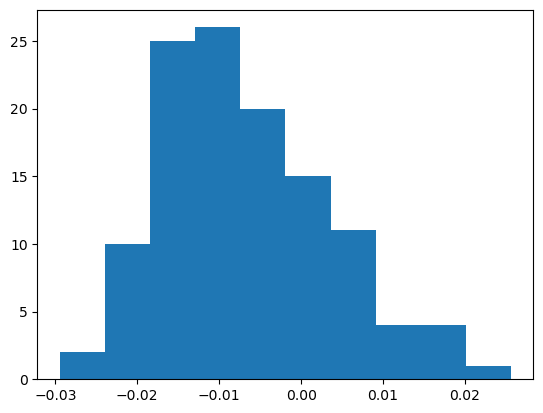

In [22]:
plt.hist(compute_ipw_estimate_inds(feat_data, "facets_neckline_V_Neck", user_ratings_df, verbose=True))

Feature: facets_sleeveLength_Sleeveless
Accuracy: 0.7116564417177914
Min prob for facets_sleeveLength_Sleeveless = True: 0.019962751216205072
Max prob for facets_sleeveLength_Sleeveless = True: 0.8532762514047031
Min prob for facets_sleeveLength_Sleeveless = False: 0.01890460396701031
Max prob for facets_sleeveLength_Sleeveless = False: 0.8750666761895793
IPW estimate of effect of facets_sleeveLength_Sleeveless on Avg_Rating: 0.008053777891716851


(array([ 1.,  4.,  6., 16., 22., 36., 16., 12.,  2.,  3.]),
 array([-0.03363027, -0.02565141, -0.01767255, -0.00969369, -0.00171483,
         0.00626404,  0.0142429 ,  0.02222176,  0.03020062,  0.03817948,
         0.04615835]),
 <BarContainer object of 10 artists>)

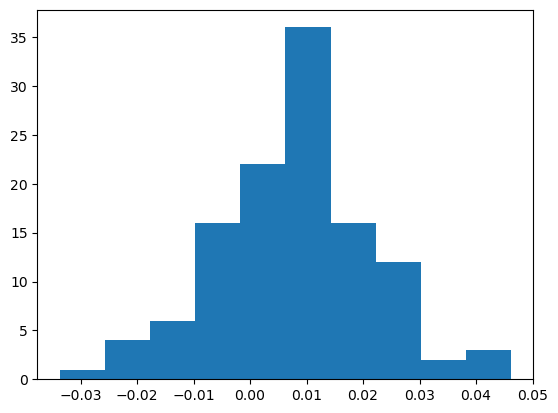

In [23]:
plt.hist(compute_ipw_estimate_inds(feat_data, "facets_sleeveLength_Sleeveless", user_ratings_df, verbose=True))

In [24]:
# Loop over these and find extreme examples to use in the paper...

In [25]:
ipw_estimates = []
for col in prod_atts.columns:
    if col.startswith('facets_'):
        ipw_estimate = compute_ipw_estimate_inds(feat_data, col, user_ratings_df)
        ipw_estimates.append(ipw_estimate)
ipw_estimates = np.array(ipw_estimates)

In [26]:
mean_ipw = np.array(ipw_estimates).mean(axis=1).round(3)

In [27]:
highest_magnitude_idcs = np.argsort(np.abs(np.array(ipw_estimates).mean(axis=1)))[::-1]

In [28]:
highest_var_idcs = np.argsort(np.abs(np.array(ipw_estimates).std(axis=1)))[::-1]

In [29]:
prod_atts.columns[highest_magnitude_idcs[:10]]

Index(['facets_dressLength_Mini', 'facets_silhouetteDress_Tunic',
       'facets_nuulyDepartment_Petite', 'facets_nuulyDepartment_Plus',
       'facets_neckline_Collared',
       'facets_customerLifestyleAesthetic_New_York', 'facets_dressLength_Maxi',
       'facets_neckline_Plunge', 'facets_silhouetteDress_Shirtdress',
       'facets_endUseEvent_Cocktail_Formal'],
      dtype='object')

In [31]:
prod_atts.columns[highest_var_idcs[::-1][:10]]

Index(['facets_constructionDetails_Tie_Closure', 'facets_fabric_Polyester',
       'facets_fabricDetail_Woven', 'facets_sleeveLength_Short_Sleeve',
       'facets_fabric_Rayon', 'facets_neckline_V_Neck', 'facets_fabric_Cotton',
       'facets_fabric_Viscose', 'facets_constructionDetails_Fully_Lined',
       'facets_weather_Year_Round'],
      dtype='object')

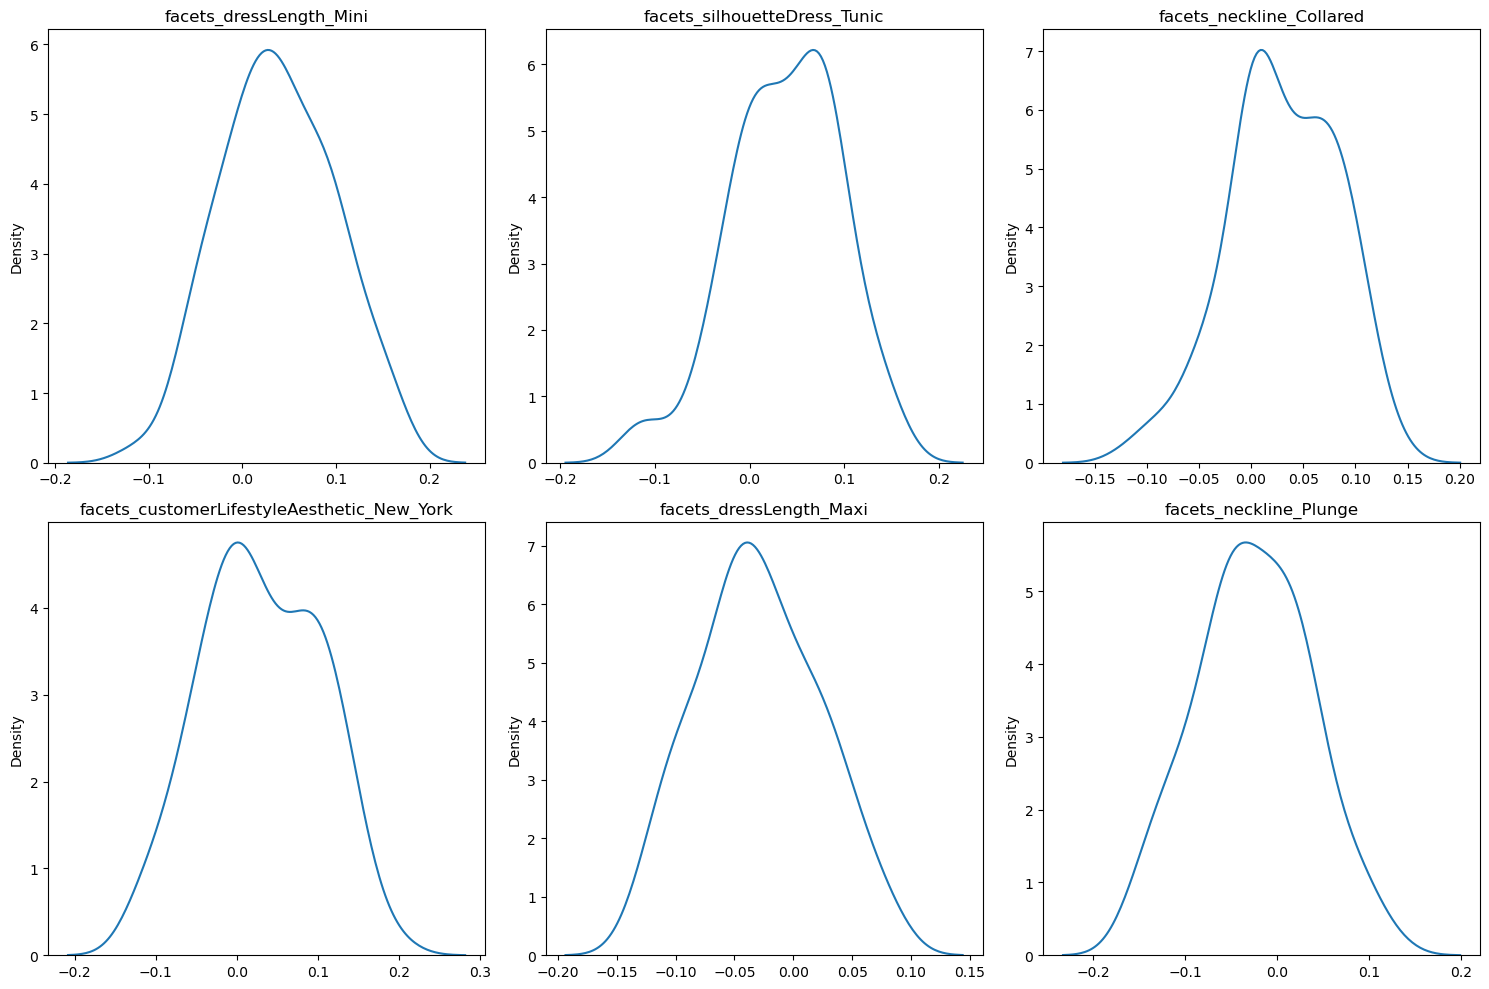

In [31]:
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
idx = [0, 1, 4, 5, 6, 7]
for i, ax in zip(idx, axs.flat):
    sns.kdeplot(ipw_estimates[highest_magnitude_idcs[i]], ax=ax)
    ax.set_title(prod_atts.columns[highest_magnitude_idcs[i]])
plt.tight_layout()


In [33]:
ipw_estimates = pd.DataFrame(ipw_estimates, index=prod_atts.columns)

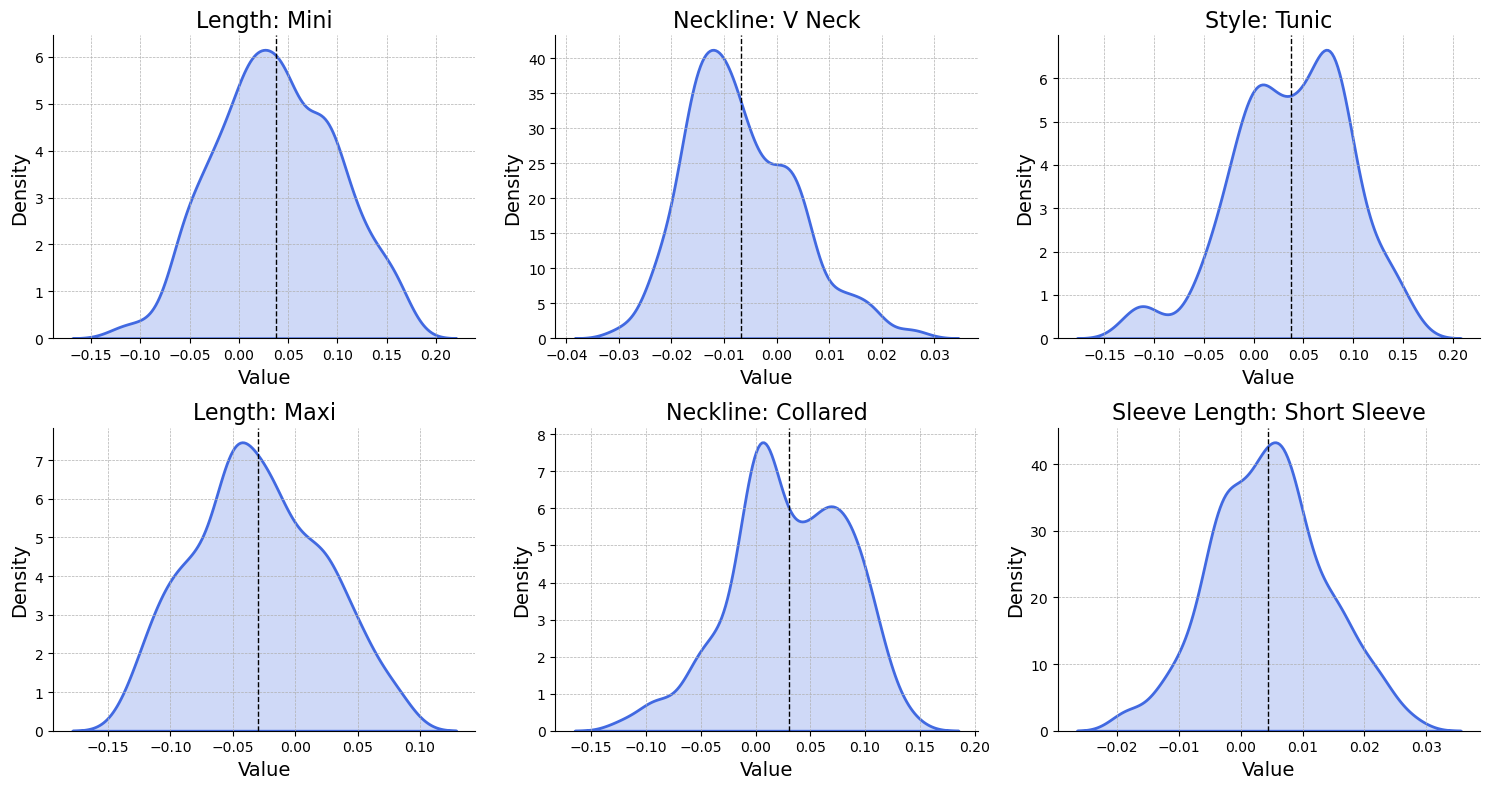

In [45]:
idx = [
    'facets_dressLength_Mini', 
    'facets_neckline_V_Neck', 
    'facets_silhouetteDress_Tunic', 
    'facets_dressLength_Maxi',
    'facets_neckline_Collared',
    'facets_sleeveLength_Short_Sleeve',
] 

titles = ['Length: Mini', 'Neckline: V Neck', 'Style: Tunic', 'Length: Maxi', 'Neckline: Collared', 'Sleeve Length: Short Sleeve']

colors = sns.color_palette("inferno", n_colors=len(idx))

fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for i, ax, color, title in zip(idx, axs.flat, colors, titles):
    sns.kdeplot(
        ipw_estimates.loc[i], 
        ax=ax, 
        color='royalblue', 
        lw=2, 
        shade=True, 
        bw_adjust=0.75
    )

    # Add vertical line at mean
    mean_value = ipw_estimates.loc[i].mean()
    ax.axvline(mean_value, color='black', linestyle='--', linewidth=1)
    
    # Set titles with provided names and increase font size
    ax.set_title(title, fontsize=16)
    
    # Add a light grid
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    
    # Set x and y labels
    ax.set_xlabel("Value", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    
    # Remove right and top spines for cleaner look
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig(target_dir + "ipw_select_atts_dists.pdf")
plt.savefig(target_dir + "ipw_select_atts_dists.png", dpi=300)

plt.show()

/tmp/ipykernel_1863053/1438766670.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(formatted_labels, fontsize=10)


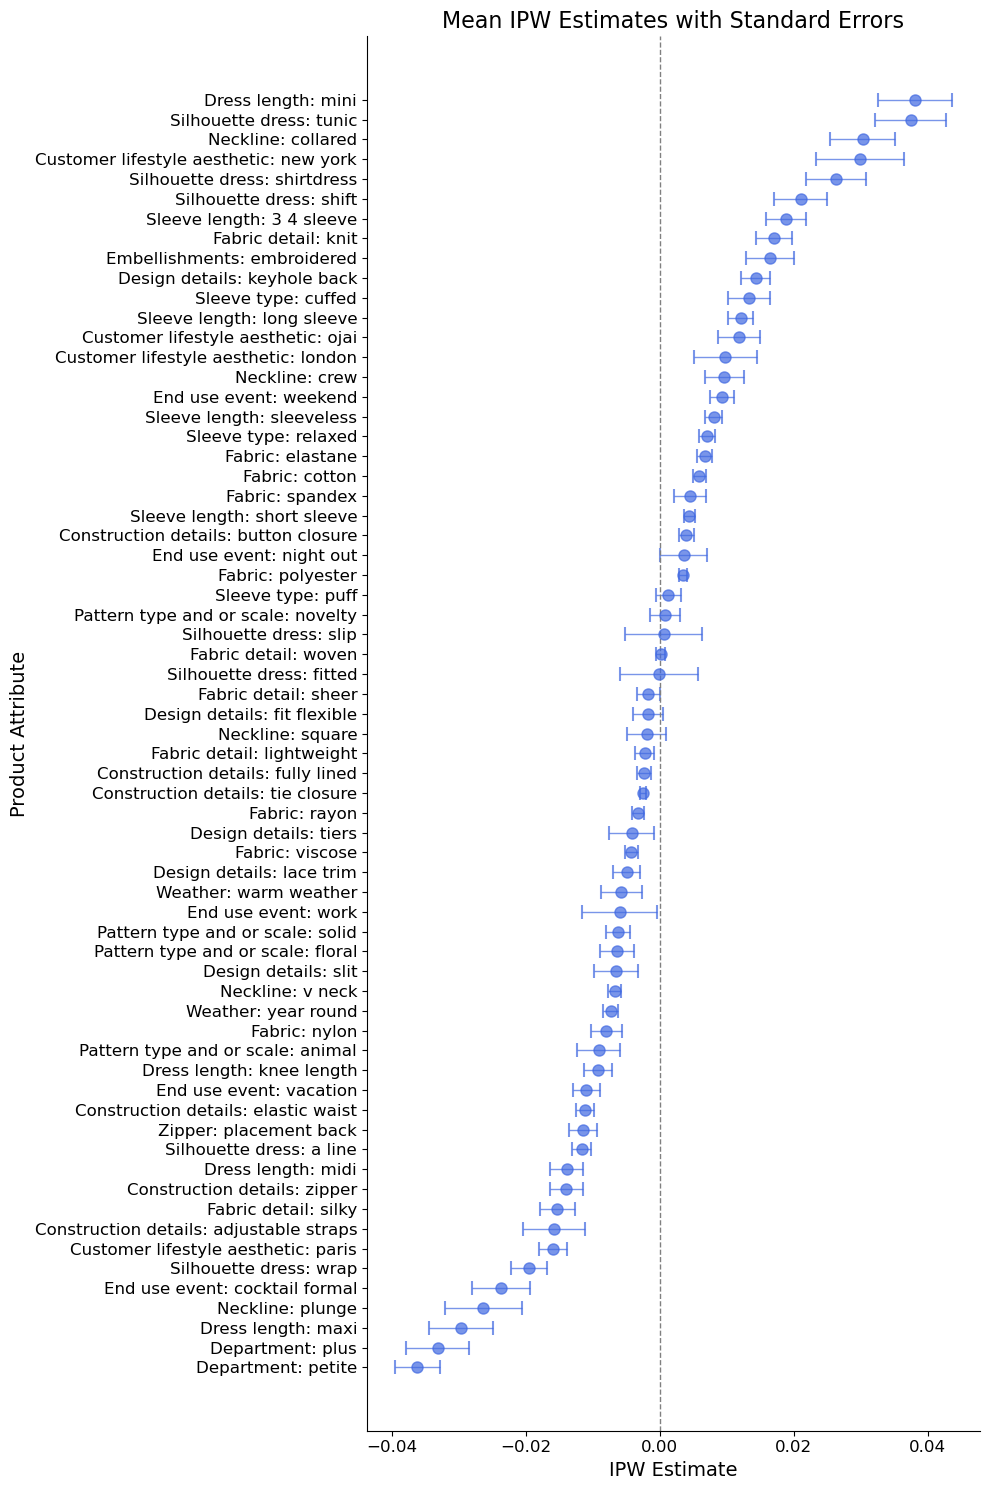

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import re

# Sample data setup (assuming you've already defined these)
# ipw_estimates, prod_atts are assumed to be previously defined in your script

# Compute mean and standard error of ipw_estimates
mean_ipw = np.array(ipw_estimates).mean(axis=1)
se_ipw = np.array(ipw_estimates).std(axis=1) / np.sqrt(np.array(ipw_estimates).shape[1])

# Function to format label
def format_label(label):
    # Remove the "facets_" prefix
    label = label.replace("facets_", "").replace("Nuuly", "").replace("nuuly", "")
    
    # Split on the first underscore
    first_part, rest = label.split('_', 1)
    
    # Separate camel case with a space for the first part
    first_part = re.sub('([a-z])([A-Z])', r'\1 \2', first_part)
    
    # Combine the two parts with a colon
    label = first_part + ": " + rest.replace("_", " ")
    
    return label.capitalize()

formatted_labels = [format_label(label) for label in prod_atts.columns]

# Sort indices by mean_ipw
sorted_indices = np.argsort(mean_ipw)

# Sort the mean_ipw, se_ipw, and formatted_labels using the sorted indices
mean_ipw = mean_ipw[sorted_indices]
se_ipw = se_ipw[sorted_indices]
formatted_labels = np.array(formatted_labels)[sorted_indices].tolist()

# Create plot
fig, ax = plt.subplots(figsize=(10, 15))

# Errorbar aesthetics
color = 'royalblue'
ax.errorbar(mean_ipw, formatted_labels, xerr=se_ipw, fmt='o', color=color, 
            capsize=5, elinewidth=1, ecolor=color, alpha=0.7, capthick=1.5, markersize=8)

# Horizontal line at x=0
ax.axvline(x=0, color='grey', linestyle='--', lw=1)

# Axis labels, title, and tick parameters
ax.set_yticklabels(formatted_labels, fontsize=10)
ax.set_ylabel('Product Attribute', fontsize=14)
ax.set_xlabel('IPW Estimate', fontsize=14)
ax.set_title('Mean IPW Estimates with Standard Errors', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

# Remove top and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(target_dir + "ipw_all_atts_sorted.pdf")
plt.savefig(target_dir + "ipw_all_atts_sorted.png", dpi=300)
plt.show()


In [42]:
len(formatted_labels)

65